In [ ]:
# !pip install pyyaml==5.1
# !pip install "git+https://github.com/facebookresearch/detectron2.git"

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

Import Detectron

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
from detectron2.data.datasets import register_coco_instances

train_data_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\nandita_google_drive_files\Pittsburg University - Xing Lab\Collab_data\data"""
train_json_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\nandita_google_drive_files\Pittsburg University - Xing Lab\coco_format\train.json"""

val_data_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\nandita_google_drive_files\Pittsburg University - Xing Lab\Collab_data\data"""
val_json_path = r"""D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\nandita_google_drive_files\Pittsburg University - Xing Lab\coco_format\val.json"""
register_coco_instances("deepfashion_train", {}, train_json_path, train_data_path)
register_coco_instances("deepfashion_val", {}, val_json_path, val_data_path)

## Detectron config

In [3]:
output_dir = "./detectron_run0_output/"
def gen_cfg():
    cfg = get_cfg()

    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )
    )
    cfg.DATASETS.TRAIN = ("deepfashion_val",)
    cfg.DATASETS.TEST = ()
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )  # Let training initialize from model zoo

    cfg.SOLVER.IMS_PER_BATCH = 4
    cfg.SOLVER.BASE_LR = 0.001
    cfg.SOLVER.WARMUP_ITERS = 1000
    cfg.SOLVER.MAX_ITER = 300
    cfg.SOLVER.STEPS = (1000, 1500)
    cfg.SOLVER.GAMMA = 0.05
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

    cfg.TEST.EVAL_PERIOD = 500
    cfg.OUTPUT_DIR = output_dir
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
        0.55  # set the testing threshold for this model
    )
    cfg.DATASETS.TEST = ("deepfashion_val",)
    return cfg
    
cfg = gen_cfg()

In [4]:
import torch
print(torch.version)
print(torch.cuda.is_available())

<module 'torch.version' from 'c:\\Users\\dummy\\Anaconda3\\envs\\cv-general\\lib\\site-packages\\torch\\version.py'>
True


In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
! tensorboard --logdir detectron_run0_output

In [5]:
cfg = gen_cfg()
cfg.OUTPUT_DIR = output_dir
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55   # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepfashion_val", )
predictor = DefaultPredictor(cfg)

[09/01 09:50:29 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [6]:
def normalize_img_by_zscore(img: np.array):
    """calculate z score of img and normalize to range [0, 255]

    Parameters
    ----------
    img : np.array
        _description_

    Returns
    -------
    _type_
        _description_
    """
    img = (img - np.mean(img.flatten()))/np.std(img.flatten())
    img = img + abs(np.min(img.flatten()))
    img = img / np.max(img) * 255
    return img

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
import livecell_segment.datasets

# dir_path = Path('D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched')
dir_path = Path('D:\\xing-vimentin-dic-pipeline\\src\\cxa_segmentation\\cxa-data\\june_2022_data\\day0_Notreat_Group1_wellA1_RI_MIP_stitched')
imgs = livecell_segment.datasets.LiveCellImageDataset(dir_path, ext="tif")

120 tif img file paths loaded: 


In [8]:
img1 = imgs[100][:, :, np.newaxis]
img1 = normalize_img_by_zscore(img1)
img2 = cv2.imread(r"D:\xing-vimentin-dic-pipeline\src\cxa_segmentation\cxa-data\nandita_google_drive_files\Pittsburg University - Xing Lab\Collab_data\data\100th_1.png")
# outputs

In [9]:
def detectron_predict_single_img(img):
    outputs = predictor(img)
    return outputs

def detectron_visualize_img(img):
    outputs = detectron_predict_single_img(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    figure = plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(v.get_image()[:, :, ::-1])

In [10]:
detectron_predict_single_img(img1)

c:\Users\dummy\Anaconda3\envs\cv-general\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'instances': Instances(num_instances=11, image_height=2408, image_width=2408, fields=[pred_boxes: Boxes(tensor([[1209.2068, 1762.7253, 1614.8854, 2004.1816],
         [ 337.5095,  117.4357,  614.2628,  616.7157],
         [ 387.5665,  306.6212,  464.9388,  393.4460],
         [ 130.4906,  157.6497,  367.0178,  373.1397],
         [ 235.0435,  283.7848,  310.4825,  358.4341],
         [1332.4470, 1881.3573, 1406.3303, 1938.3672],
         [1101.1316, 1300.1930, 1414.0378, 1559.3766],
         [ 137.4621,  347.6761,  359.1931,  588.6026],
         [2045.0801,  786.9400, 2199.2651,  901.0070],
         [ 247.0372,  374.5856,  314.8746,  448.9142],
         [1192.6478,   22.2452, 1488.8425,  285.8594]], device='cuda:0')), scores: tensor([0.8852, 0.7922, 0.7883, 0.7498, 0.7298, 0.6957, 0.6705, 0.6665, 0.6594,
         0.6526, 0.5694], device='cuda:0'), pred_classes: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, Fa

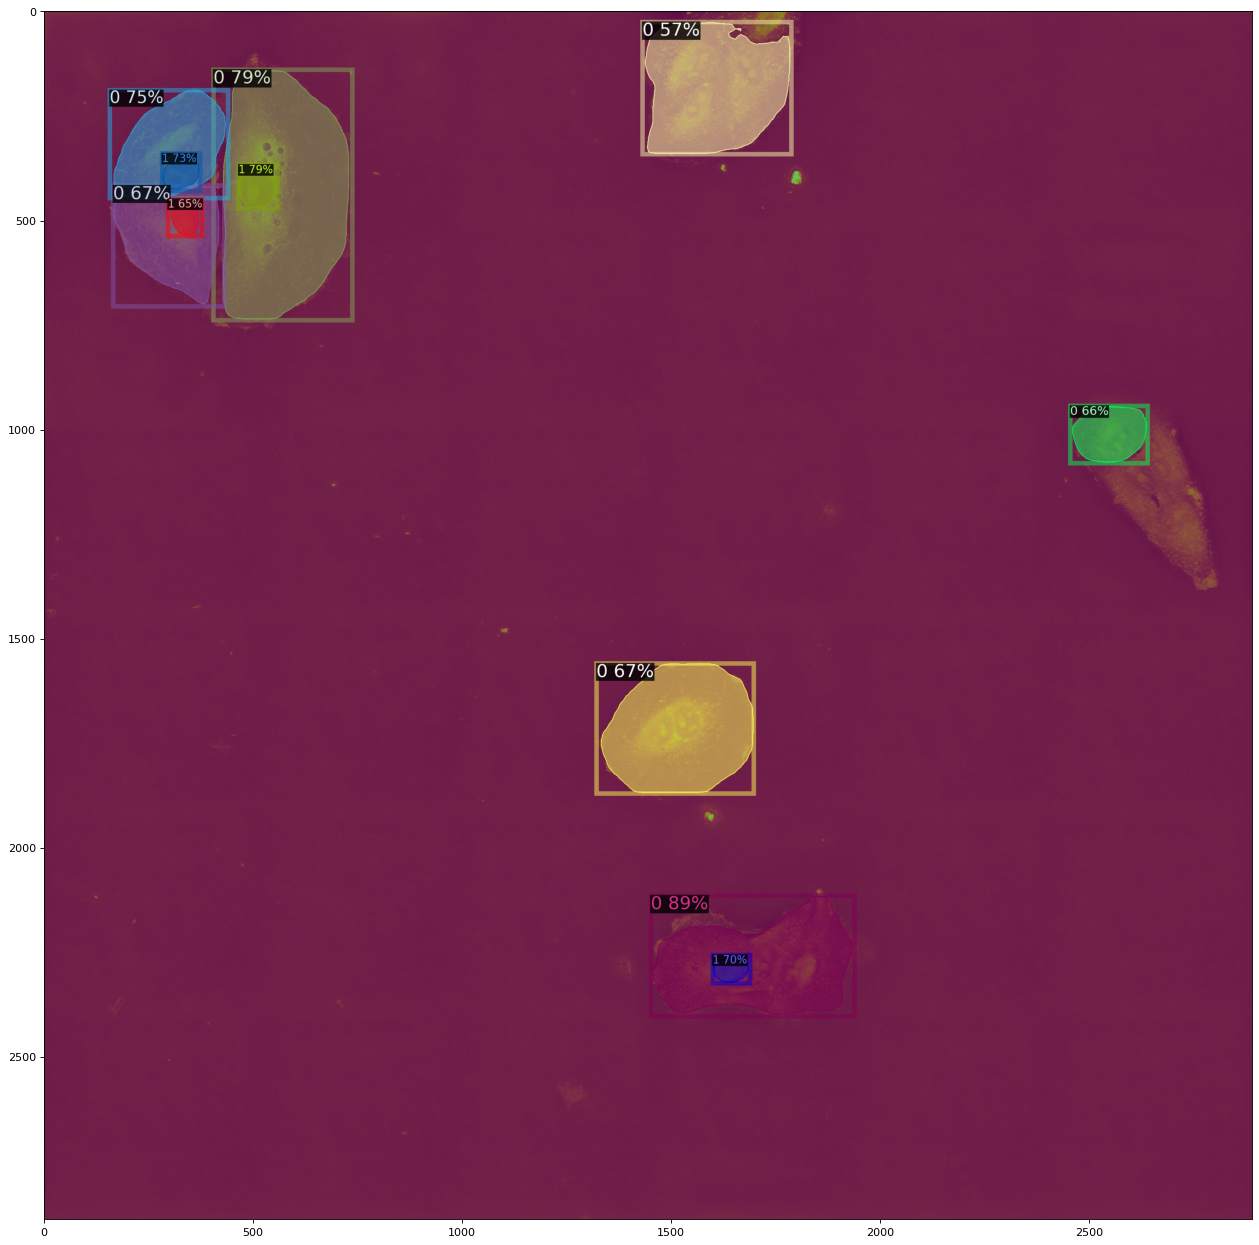

In [11]:
detectron_visualize_img(img1)

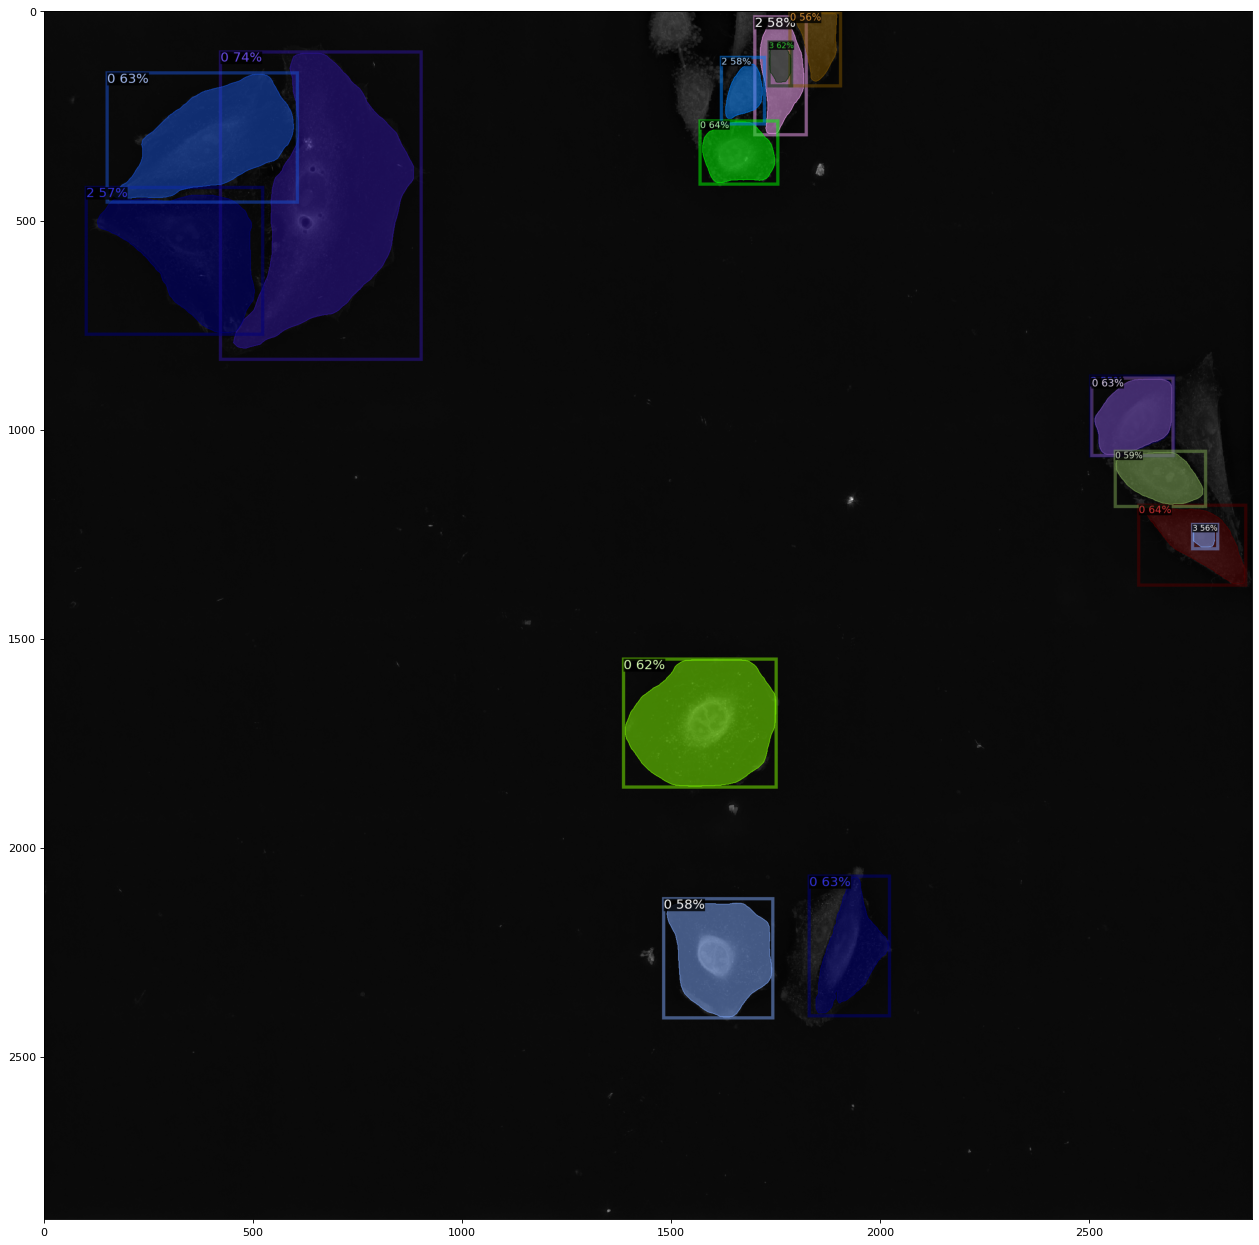

In [12]:
detectron_visualize_img(img2)

In [13]:
img1[:5, 0], img2[:5, 0]

(array([[37.117035],
        [37.14809 ],
        [37.068382],
        [37.12014 ],
        [36.262505]], dtype=float32),
 array([[13, 13, 13],
        [13, 13, 13],
        [13, 13, 13],
        [12, 12, 12],
        [12, 12, 12]], dtype=uint8))

In [14]:
img1[:5, 0], normalize_img_by_zscore(img2)[:5, 0]

(array([[37.117035],
        [37.14809 ],
        [37.068382],
        [37.12014 ],
        [36.262505]], dtype=float32),
 array([[13., 13., 13.],
        [13., 13., 13.],
        [13., 13., 13.],
        [12., 12., 12.],
        [12., 12., 12.]]))